In [1]:
pip install -q deeplake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.7/617.7 kB 26.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.6 MB/s eta 

In [2]:
import deeplake
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# Hyperparameters
batch_size = 5
num_epochs = 1
learning_rate = 0.001

In [4]:
train_ds = deeplake.load("hub://activeloop/pacs-train")
test_ds = deeplake.load("hub://activeloop/pacs-test")

/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train



|

hub://activeloop/pacs-train loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-test



/

hub://activeloop/pacs-test loaded successfully.



In [5]:
train_ds.visualize()

HINT: Please forward the port - 58127 to your local machine, if you are running on the cloud.
 * Serving Flask app 'dataset_visualizer'
 * Debug mode: off


In [6]:
test_ds.visualize()

In [7]:
train_loader = train_ds.pytorch(num_workers=0, batch_size = batch_size, shuffle = False)
test_loader = test_ds.pytorch(num_workers=0, batch_size = batch_size, shuffle = False)

/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:137: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


In [8]:
# Load pretrained ResNet-50
model = torchvision.models.resnet50(pretrained=True)

# Replace the classifier head
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)  # 7 classes for PCAS Dataset
# Freeze the backbone
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True
# Move model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]


In [9]:
# Fine-tuning the model
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    train_loss_list = []
    train_accuracy_list = []
    for epoch in tqdm(range(num_epochs)):

        running_loss = 0.0
        total = 0
        correct = 0

        for images, labels,_,_ in tqdm(train_loader):
            images = images.reshape(-1, 3, 227, 227).float()
            labels = labels.squeeze()
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        train_accuracy_list.append(accuracy)
        train_loss_list.append(running_loss / len(train_loader))

    return train_loss_list,train_accuracy_list

In [10]:
# Evaluate the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels,_,_ in tqdm(test_loader):
            images = images.reshape(-1, 3, 227, 227).float()
            labels = labels.view(-1)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct/total*100
    return accuracy


In [11]:
# Training and evaluation
train_loss_list, train_accuracy_list = train_model(model, train_loader, criterion, optimizer)
test_accuracy = test_model(model, test_loader)
print(f'Accuracy of the model on the test images: {test_accuracy:.2f}%')

100%|██████████| 1999/1999 [00:48<00:00, 41.08it/s]

Accuracy of the model on the test images: 14.47%


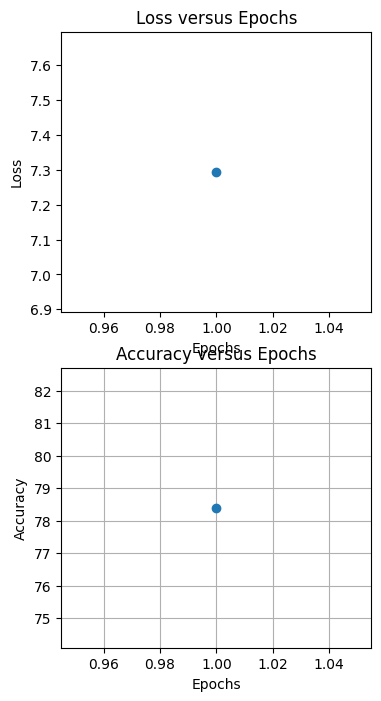

In [12]:
# Plotting the accuracy and loss curves curves

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(4, 8))

ax1.plot(range(1, num_epochs + 1), train_loss_list, marker='o')
ax1.set_title('Loss versus Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(range(1, num_epochs + 1), train_accuracy_list, marker='o')
ax2.set_title('Accuracy versus Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.grid()
plt.show()